# Detecção de Alzheimer com CNN Invariante à Resolução

Este notebook implementa um modelo CNN para detecção da doença de Alzheimer que pode lidar com imagens de diferentes resoluções mantendo alta precisão.

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from tqdm import tqdm
import json
from models.AlzheimerCNN import AlzheimerCNN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Pré-processamento dos Dados

O pipeline de pré-processamento é projetado para lidar com diferentes tamanhos de imagem mantendo as proporções e adicionando robustez através de aumento de dados.

In [7]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Carregando o Dataset

Carrega os datasets de treinamento e teste com as novas transformações.

In [8]:
# Atualize estes caminhos para as localizações do seu dataset
train_dataset = datasets.ImageFolder(root='D:/Projetos/TrabalhoFinalDataScience/AlzheimerEarlyDetection/datasets/train', transform=train_transform)
test_dataset = datasets.ImageFolder(root='D:/Projetos/TrabalhoFinalDataScience/AlzheimerEarlyDetection/datasets/test', transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Criar o mapeamento de classes com base no class_to_idx
CLASS_MAPPING = {str(idx): class_name for class_name, idx in train_dataset.class_to_idx.items()}

# Imprime o mapeamento das classes
class_to_idx = train_dataset.class_to_idx
print("Mapeamento de Classes:")
for class_name, class_index in class_to_idx.items():
    print(f"{class_index}: {class_name}")

# Salvar o mapeamento de classes
with open('models/class_mapping.json', 'w') as f:
    json.dump(CLASS_MAPPING, f)

Mapeamento de Classes:
0: Mild Impairment
1: Moderate Impairment
2: No Impairment
3: Very Mild Impairment


## Treinamento do Modelo

Loop de treinamento com acompanhamento de progresso e salvamento do modelo.

In [9]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=100):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    
    best_accuracy = 0.0
    
    for epoch in range(num_epochs):
        # Fase de treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        train_loop = tqdm(train_loader, desc=f'Época {epoch+1}/{num_epochs} [Treino]')
        for images, labels in train_loop:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            train_loop.set_postfix(loss=loss.item(), acc=100.*correct/total)
        
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        
        # Fase de teste
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            test_loop = tqdm(test_loader, desc=f'Época {epoch+1}/{num_epochs} [Teste]')
            for images, labels in test_loop:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
                
                test_loop.set_postfix(loss=loss.item(), acc=100.*test_correct/test_total)
        
        test_epoch_loss = test_loss / len(test_loader)
        test_epoch_accuracy = 100 * test_correct / test_total
        test_losses.append(test_epoch_loss)
        test_accuracies.append(test_epoch_accuracy)
        
        # Salva o melhor modelo
        if test_epoch_accuracy > best_accuracy:
            best_accuracy = test_epoch_accuracy
            torch.save(model.state_dict(), 'models/alzheimer_mri_model.pth')
        
        print(f'Época [{epoch+1}/{num_epochs}], '
              f'Perda Treino: {epoch_loss:.4f}, Acurácia Treino: {epoch_accuracy:.2f}%, '
              f'Perda Teste: {test_epoch_loss:.4f}, Acurácia Teste: {test_epoch_accuracy:.2f}%')
    
    return train_losses, train_accuracies, test_losses, test_accuracies

## Inicializa e Treina o Modelo

In [10]:
model = AlzheimerCNN(num_classes=4)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, train_accuracies, test_losses, test_accuracies = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs=50
)

Época 1/50 [Teste]: 100%|██████████| 40/40 [00:09<00:00,  4.26it/s, acc=54.7, loss=0.788]


Época [1/50], Perda Treino: 1.0775, Acurácia Treino: 49.63%, Perda Teste: 0.9558, Acurácia Teste: 54.65%


Época 2/50 [Teste]: 100%|██████████| 40/40 [00:09<00:00,  4.24it/s, acc=58.7, loss=0.857]


Época [2/50], Perda Treino: 0.6878, Acurácia Treino: 68.24%, Perda Teste: 0.8067, Acurácia Teste: 58.72%


Época 3/50 [Teste]: 100%|██████████| 40/40 [00:09<00:00,  4.20it/s, acc=61.7, loss=0.888]


Época [3/50], Perda Treino: 0.6107, Acurácia Treino: 72.56%, Perda Teste: 0.7817, Acurácia Teste: 61.69%


Época 4/50 [Teste]: 100%|██████████| 40/40 [00:09<00:00,  4.18it/s, acc=62.9, loss=0.569]


Época [4/50], Perda Treino: 0.5622, Acurácia Treino: 74.73%, Perda Teste: 0.7604, Acurácia Teste: 62.94%


Época 5/50 [Teste]: 100%|██████████| 40/40 [00:09<00:00,  4.09it/s, acc=63.7, loss=0.749]


Época [5/50], Perda Treino: 0.5296, Acurácia Treino: 76.13%, Perda Teste: 0.7501, Acurácia Teste: 63.72%


Época 6/50 [Teste]: 100%|██████████| 40/40 [00:09<00:00,  4.08it/s, acc=64.3, loss=0.764]


Época [6/50], Perda Treino: 0.5053, Acurácia Treino: 77.41%, Perda Teste: 0.7330, Acurácia Teste: 64.35%


Época 7/50 [Teste]: 100%|██████████| 40/40 [00:09<00:00,  4.19it/s, acc=65.1, loss=0.542]


Época [7/50], Perda Treino: 0.4845, Acurácia Treino: 78.68%, Perda Teste: 0.7050, Acurácia Teste: 65.13%


Época 8/50 [Teste]: 100%|██████████| 40/40 [00:09<00:00,  4.24it/s, acc=66.4, loss=0.62] 


Época [8/50], Perda Treino: 0.4491, Acurácia Treino: 79.51%, Perda Teste: 0.7313, Acurácia Teste: 66.38%


Época 9/50 [Teste]: 100%|██████████| 40/40 [00:09<00:00,  4.16it/s, acc=69.4, loss=0.617]


Época [9/50], Perda Treino: 0.4410, Acurácia Treino: 80.21%, Perda Teste: 0.6744, Acurácia Teste: 69.35%


Época 10/50 [Teste]: 100%|██████████| 40/40 [00:09<00:00,  4.22it/s, acc=69.5, loss=0.773]


Época [10/50], Perda Treino: 0.4262, Acurácia Treino: 81.49%, Perda Teste: 0.6265, Acurácia Teste: 69.51%


Época 11/50 [Teste]: 100%|██████████| 40/40 [00:09<00:00,  4.15it/s, acc=69, loss=0.61]   


Época [11/50], Perda Treino: 0.4021, Acurácia Treino: 82.52%, Perda Teste: 0.6406, Acurácia Teste: 68.96%


Época 12/50 [Teste]: 100%|██████████| 40/40 [00:09<00:00,  4.06it/s, acc=73.1, loss=0.573]


Época [12/50], Perda Treino: 0.3991, Acurácia Treino: 82.50%, Perda Teste: 0.5833, Acurácia Teste: 73.10%


Época 13/50 [Teste]: 100%|██████████| 40/40 [00:09<00:00,  4.22it/s, acc=72, loss=0.606]  


Época [13/50], Perda Treino: 0.3754, Acurácia Treino: 84.00%, Perda Teste: 0.5854, Acurácia Teste: 72.01%


Época 14/50 [Teste]: 100%|██████████| 40/40 [00:09<00:00,  4.15it/s, acc=72.3, loss=0.616]


Época [14/50], Perda Treino: 0.3688, Acurácia Treino: 83.77%, Perda Teste: 0.5706, Acurácia Teste: 72.32%


Época 15/50 [Teste]: 100%|██████████| 40/40 [00:09<00:00,  4.16it/s, acc=73.4, loss=0.476]


Época [15/50], Perda Treino: 0.3621, Acurácia Treino: 84.37%, Perda Teste: 0.5525, Acurácia Teste: 73.42%


Época 16/50 [Teste]: 100%|██████████| 40/40 [00:09<00:00,  4.15it/s, acc=73.2, loss=0.396]


Época [16/50], Perda Treino: 0.3435, Acurácia Treino: 84.91%, Perda Teste: 0.6031, Acurácia Teste: 73.18%


Época 17/50 [Teste]: 100%|██████████| 40/40 [00:09<00:00,  4.30it/s, acc=75.8, loss=0.795]


Época [17/50], Perda Treino: 0.3401, Acurácia Treino: 85.31%, Perda Teste: 0.5456, Acurácia Teste: 75.76%


Época 18/50 [Teste]: 100%|██████████| 40/40 [00:09<00:00,  4.15it/s, acc=76.4, loss=0.636]


Época [18/50], Perda Treino: 0.3387, Acurácia Treino: 85.20%, Perda Teste: 0.5098, Acurácia Teste: 76.39%


Época 19/50 [Teste]: 100%|██████████| 40/40 [00:09<00:00,  4.21it/s, acc=78.3, loss=0.586]


Época [19/50], Perda Treino: 0.3282, Acurácia Treino: 86.10%, Perda Teste: 0.4751, Acurácia Teste: 78.26%


Época 20/50 [Teste]: 100%|██████████| 40/40 [00:09<00:00,  4.24it/s, acc=78.1, loss=0.536]


Época [20/50], Perda Treino: 0.3136, Acurácia Treino: 86.66%, Perda Teste: 0.5042, Acurácia Teste: 78.11%


Época 21/50 [Teste]: 100%|██████████| 40/40 [00:09<00:00,  4.30it/s, acc=79.3, loss=0.694]


Época [21/50], Perda Treino: 0.3074, Acurácia Treino: 86.73%, Perda Teste: 0.4552, Acurácia Teste: 79.28%


Época 22/50 [Teste]: 100%|██████████| 40/40 [00:09<00:00,  4.19it/s, acc=81.3, loss=0.52] 


Época [22/50], Perda Treino: 0.2937, Acurácia Treino: 87.41%, Perda Teste: 0.4206, Acurácia Teste: 81.31%


Época 23/50 [Teste]: 100%|██████████| 40/40 [00:09<00:00,  4.19it/s, acc=82.6, loss=0.503]


Época [23/50], Perda Treino: 0.2946, Acurácia Treino: 87.56%, Perda Teste: 0.4081, Acurácia Teste: 82.56%


Época 24/50 [Teste]: 100%|██████████| 40/40 [00:09<00:00,  4.29it/s, acc=81.6, loss=0.31] 


Época [24/50], Perda Treino: 0.2833, Acurácia Treino: 87.79%, Perda Teste: 0.4407, Acurácia Teste: 81.63%


Época 25/50 [Teste]: 100%|██████████| 40/40 [00:09<00:00,  4.20it/s, acc=82.4, loss=0.606]


Época [25/50], Perda Treino: 0.2732, Acurácia Treino: 88.60%, Perda Teste: 0.4046, Acurácia Teste: 82.41%


Época 26/50 [Teste]: 100%|██████████| 40/40 [00:09<00:00,  4.20it/s, acc=82.9, loss=0.515]


Época [26/50], Perda Treino: 0.2796, Acurácia Treino: 88.10%, Perda Teste: 0.3973, Acurácia Teste: 82.88%


Época 27/50 [Teste]: 100%|██████████| 40/40 [00:09<00:00,  4.36it/s, acc=85.8, loss=0.479]


Época [27/50], Perda Treino: 0.2761, Acurácia Treino: 88.31%, Perda Teste: 0.3545, Acurácia Teste: 85.77%


Época 28/50 [Teste]: 100%|██████████| 40/40 [00:09<00:00,  4.21it/s, acc=84.9, loss=0.653] 


Época [28/50], Perda Treino: 0.2636, Acurácia Treino: 89.07%, Perda Teste: 0.3629, Acurácia Teste: 84.91%


Época 29/50 [Teste]: 100%|██████████| 40/40 [00:09<00:00,  4.27it/s, acc=85.8, loss=0.523] 


Época [29/50], Perda Treino: 0.2588, Acurácia Treino: 89.33%, Perda Teste: 0.3662, Acurácia Teste: 85.77%


Época 30/50 [Teste]: 100%|██████████| 40/40 [00:09<00:00,  4.26it/s, acc=86.8, loss=0.266]


Época [30/50], Perda Treino: 0.2445, Acurácia Treino: 89.95%, Perda Teste: 0.3297, Acurácia Teste: 86.79%


Época 31/50 [Teste]: 100%|██████████| 40/40 [00:09<00:00,  4.22it/s, acc=88, loss=0.301]  


Época [31/50], Perda Treino: 0.2461, Acurácia Treino: 89.78%, Perda Teste: 0.3247, Acurácia Teste: 88.04%


Época 32/50 [Teste]: 100%|██████████| 40/40 [00:09<00:00,  4.34it/s, acc=85.8, loss=0.428]


Época [32/50], Perda Treino: 0.2413, Acurácia Treino: 89.64%, Perda Teste: 0.3463, Acurácia Teste: 85.77%


Época 33/50 [Teste]: 100%|██████████| 40/40 [00:09<00:00,  4.30it/s, acc=86.5, loss=0.352] 


Época [33/50], Perda Treino: 0.2478, Acurácia Treino: 89.97%, Perda Teste: 0.3272, Acurácia Teste: 86.47%


Época 34/50 [Teste]: 100%|██████████| 40/40 [00:09<00:00,  4.26it/s, acc=85.7, loss=0.402] 


Época [34/50], Perda Treino: 0.2291, Acurácia Treino: 90.39%, Perda Teste: 0.3267, Acurácia Teste: 85.69%


Época 35/50 [Teste]: 100%|██████████| 40/40 [00:09<00:00,  4.25it/s, acc=86.6, loss=0.174]


Época [35/50], Perda Treino: 0.2284, Acurácia Treino: 90.75%, Perda Teste: 0.3264, Acurácia Teste: 86.55%


Época 36/50 [Teste]: 100%|██████████| 40/40 [00:09<00:00,  4.24it/s, acc=89.3, loss=0.369]


Época [36/50], Perda Treino: 0.2326, Acurácia Treino: 90.36%, Perda Teste: 0.2745, Acurácia Teste: 89.29%


Época 37/50 [Teste]: 100%|██████████| 40/40 [00:09<00:00,  4.27it/s, acc=85.1, loss=0.176] 


Época [37/50], Perda Treino: 0.2200, Acurácia Treino: 90.97%, Perda Teste: 0.3481, Acurácia Teste: 85.14%


Época 38/50 [Teste]: 100%|██████████| 40/40 [00:09<00:00,  4.19it/s, acc=86.3, loss=0.301] 


Época [38/50], Perda Treino: 0.2131, Acurácia Treino: 91.17%, Perda Teste: 0.3110, Acurácia Teste: 86.32%


Época 39/50 [Teste]: 100%|██████████| 40/40 [00:09<00:00,  4.26it/s, acc=89.6, loss=0.174]


Época [39/50], Perda Treino: 0.2049, Acurácia Treino: 91.82%, Perda Teste: 0.2709, Acurácia Teste: 89.60%


Época 40/50 [Teste]: 100%|██████████| 40/40 [00:09<00:00,  4.19it/s, acc=87.8, loss=0.376] 


Época [40/50], Perda Treino: 0.2097, Acurácia Treino: 91.44%, Perda Teste: 0.2908, Acurácia Teste: 87.80%


Época 41/50 [Teste]: 100%|██████████| 40/40 [00:09<00:00,  4.26it/s, acc=89.5, loss=0.19]  


Época [41/50], Perda Treino: 0.2133, Acurácia Treino: 91.63%, Perda Teste: 0.2816, Acurácia Teste: 89.52%


Época 42/50 [Teste]: 100%|██████████| 40/40 [00:09<00:00,  4.19it/s, acc=88.7, loss=0.227] 


Época [42/50], Perda Treino: 0.2030, Acurácia Treino: 91.96%, Perda Teste: 0.2714, Acurácia Teste: 88.66%


Época 43/50 [Teste]: 100%|██████████| 40/40 [00:09<00:00,  4.15it/s, acc=89, loss=0.315]   


Época [43/50], Perda Treino: 0.2062, Acurácia Treino: 91.69%, Perda Teste: 0.2917, Acurácia Teste: 88.98%


Época 44/50 [Teste]: 100%|██████████| 40/40 [00:09<00:00,  4.14it/s, acc=90.3, loss=0.341] 


Época [44/50], Perda Treino: 0.1906, Acurácia Treino: 92.45%, Perda Teste: 0.2571, Acurácia Teste: 90.30%


Época 45/50 [Teste]: 100%|██████████| 40/40 [00:09<00:00,  4.26it/s, acc=91.6, loss=0.194] 


Época [45/50], Perda Treino: 0.1928, Acurácia Treino: 91.99%, Perda Teste: 0.2255, Acurácia Teste: 91.63%


Época 46/50 [Teste]: 100%|██████████| 40/40 [00:09<00:00,  4.32it/s, acc=91.4, loss=0.236] 


Época [46/50], Perda Treino: 0.1895, Acurácia Treino: 92.44%, Perda Teste: 0.2073, Acurácia Teste: 91.40%


Época 47/50 [Teste]: 100%|██████████| 40/40 [00:09<00:00,  4.24it/s, acc=90.5, loss=0.223] 


Época [47/50], Perda Treino: 0.1921, Acurácia Treino: 92.20%, Perda Teste: 0.2426, Acurácia Teste: 90.46%


Época 48/50 [Teste]: 100%|██████████| 40/40 [00:09<00:00,  4.25it/s, acc=90.1, loss=0.174] 


Época [48/50], Perda Treino: 0.1785, Acurácia Treino: 92.79%, Perda Teste: 0.2570, Acurácia Teste: 90.07%


Época 49/50 [Teste]: 100%|██████████| 40/40 [00:09<00:00,  4.27it/s, acc=91, loss=0.134]   


Época [49/50], Perda Treino: 0.1906, Acurácia Treino: 92.31%, Perda Teste: 0.2406, Acurácia Teste: 91.01%


Época 50/50 [Teste]: 100%|██████████| 40/40 [00:09<00:00,  4.28it/s, acc=91.9, loss=0.209] 


Época [50/50], Perda Treino: 0.1755, Acurácia Treino: 92.93%, Perda Teste: 0.2106, Acurácia Teste: 91.95%


## Avaliação do Modelo

C:\Users\Lucas\AppData\Local\Temp\ipykernel_15464\937274395.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/alzheimer_mri_model

                      precision    recall  f1-score   support

     Mild Impairment       0.91      0.93      0.92       179
 Moderate Impairment       0.92      1.00      0.96        12
       No Impairment       0.91      0.96      0.93       640
Very Mild Impairment       0.94      0.85      0.90       448

            accuracy                           0.92      1279
           macro avg       0.92      0.94      0.93      1279
        weighted avg       0.92      0.92      0.92      1279

Confusion Matrix:


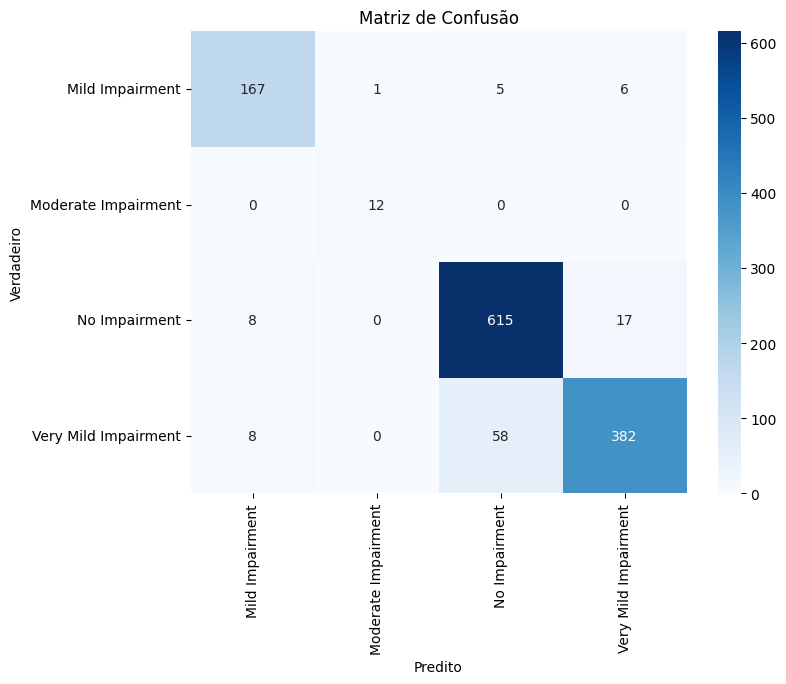

In [11]:
def evaluate_model(model, test_loader, class_to_idx):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Evaluating'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Print classification report
    class_names = [class_name for class_name, _ in sorted(class_to_idx.items(), key=lambda x: x[1])]
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # Print confusion matrix
    print("Confusion Matrix:")
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Matriz de Confusão')
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.show()
    
    return all_preds, all_labels

# Load best model
model.load_state_dict(torch.load('models/alzheimer_mri_model.pth'))

# Evaluate
predictions, true_labels = evaluate_model(model, test_loader, class_to_idx)